- Check for Colab Env
> if we are in colab env we need to get the data + scripts from github or somewhere

In [1]:
import os
if "COLAB_GPU" in os.environ:
    os.system("git clone https://github.com/zaxo7/UNet-Playground.git")
    os.chdir("/content/UNet-Playground/")


- enable module autoreload and fix an import bug

In [2]:
%load_ext autoreload
%autoreload 2

import sys,os
sys.path.append(os.getcwd() + '/scripts')

- import the scripts and data

In [3]:
from scripts import data, model
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

2022-04-30 16:48:39.263841: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/zaxo7/tensorflow/lib/python3.8/site-packages/cv2/../../lib64:
2022-04-30 16:48:39.263862: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


- load the dataset

In [26]:
train_img_files = glob.glob('data/train/*.jpg')
test_img_files = glob.glob('data/test/*.jpg')

imgs, mask, edge = data.load_data(test_img_files)

imgs_orig = data.load_image_list(test_img_files)

test_img_chips, test_mask_chips, test_edge_chips = model.generate_test_dataset(test_img_files)

- create the model and compile it

In [5]:
unet = model.get_do_unet()

2022-04-30 16:48:47.469045: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/zaxo7/tensorflow/lib/python3.8/site-packages/cv2/../../lib64:
2022-04-30 16:48:47.469080: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-30 16:48:47.469123: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (zx-d): /proc/driver/nvidia/version does not exist
2022-04-30 16:48:47.469353: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


- load weights

In [6]:
_model_name = 'tversky_b_250'
unet.load_weights(f"models/{_model_name}_best.h5")

- check model accuracy

In [ ]:
test_results = unet.evaluate(test_img_chips, (test_mask_chips, test_edge_chips), verbose=1)

In [10]:
#save the evaluation results into a file
import json
with open(f"models/{_model_name}_evaluation_results.json", "w") as fp:
    json.dump(test_results,fp)

# Opening JSON file
with open(f"models/{_model_name}_evaluation_results.json") as fp:

  test_results = json.load(fp)

- calculate mask for image

In [180]:
images, masks, edges = model.predictFullImage(unet,
                          imgs,
                        padding=100,
                        input_size=188,
                        output_size=100,
                        normalize_output = False)


- plot the results

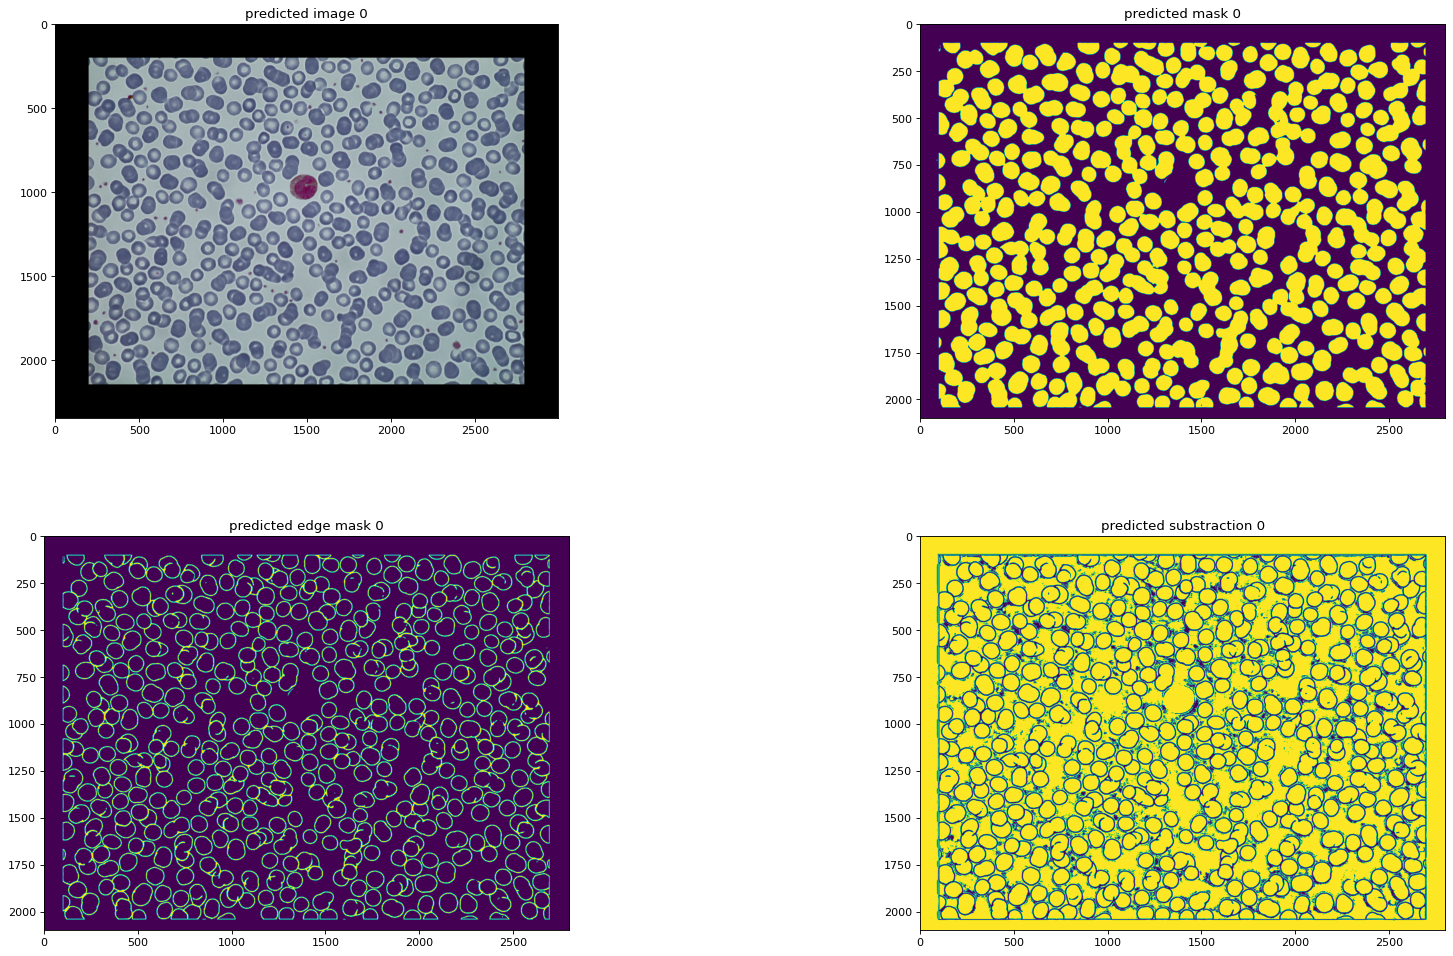

In [181]:
data.plot_ime(images,
              masks,
              edges,
              figSize=(25,15),
              max_plots = 1)



- try to detect circles in the image (from the edge mask)

In [182]:
import cv2

ind = 0

image = imgs_orig[ind].copy()
mask = masks[ind].copy() * 255
edge_mask = edges[ind].copy() * 255

edge_mask = edge_mask.astype('uint8')

In [183]:
circles = cv2.HoughCircles(edge_mask, cv2.HOUGH_GRADIENT, 1, minDist= 30,
                          param1=50, param2=12,
                          minRadius=30, maxRadius=65)
circles = (circles[0]).astype(np.uint)

print(f"found {len(circles)} circles")





found 718 circles


- draw the circles on the image

In [184]:
edge_mask_circ = edge_mask.copy()
for i in np.arange(len(circles)):
    cv2.circle(edge_mask_circ, (circles[i,0], circles[i,1]), circles[i,2], color=(127,127,127), thickness=3)
    #Draw Center (red)
    cv2.circle(edge_mask_circ, (circles[i,0], circles[i,1]), 3, color=(127,127,127), thickness=4)

True

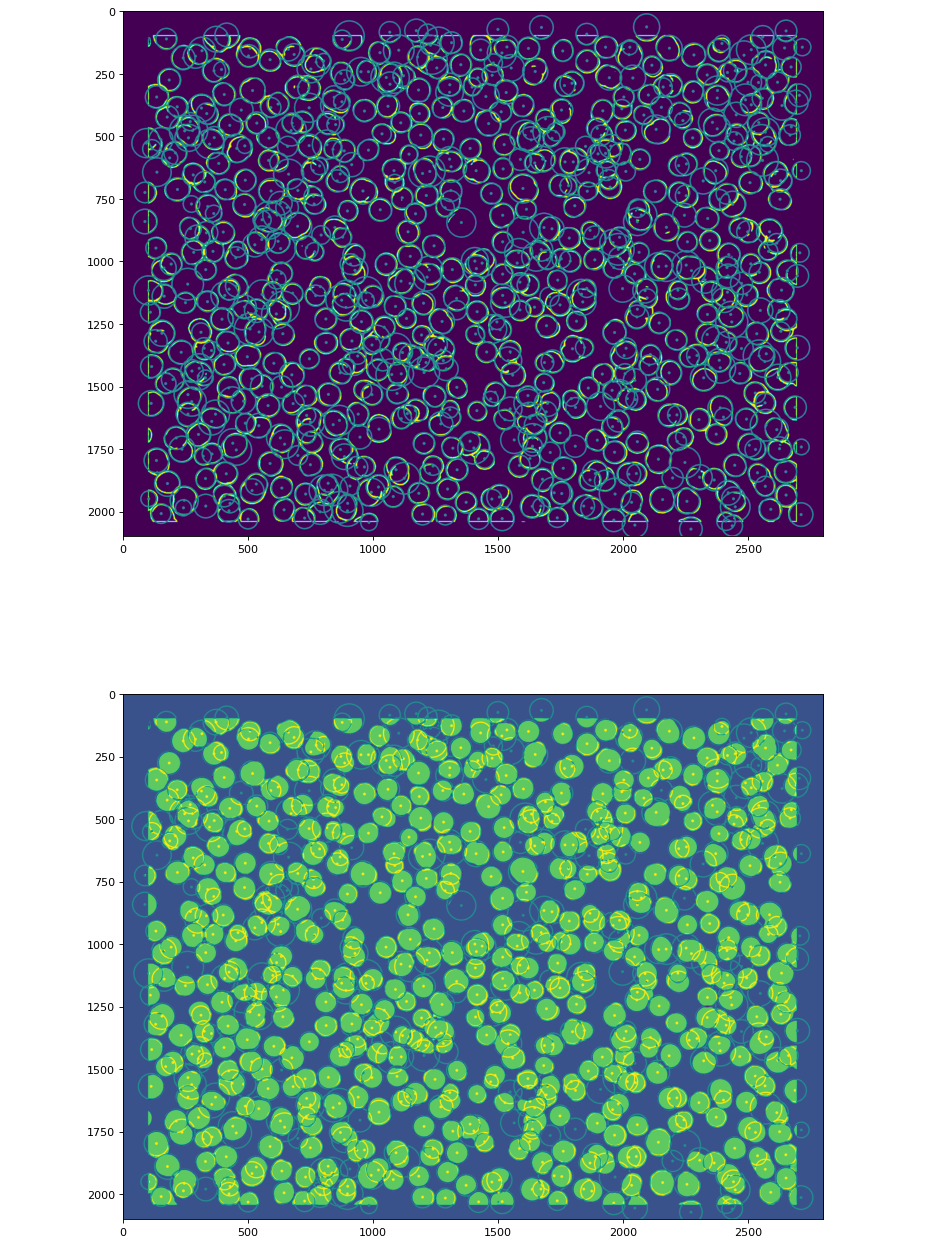

In [185]:

fig = plt.figure(figsize=(15, 20), dpi=80)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
lines = 2
columns = 1
fig_num = 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("")
ax.axis("off")
fig_num = 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("")
ax.imshow(edge_mask_circ)
fig_num = fig_num + 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("")
ax.imshow((edge_mask_circ + mask) - edge_mask)

cv2.imwrite("img.png", edge_mask_circ)

- load how many cirlces in image

In [186]:
polygon_list = data.make_polygon_lists(["data/test/Im045_0.json"])[0]
len(polygon_list)

601

- detect how many cells with non connected regions method from the diffrence between mask and edge mask

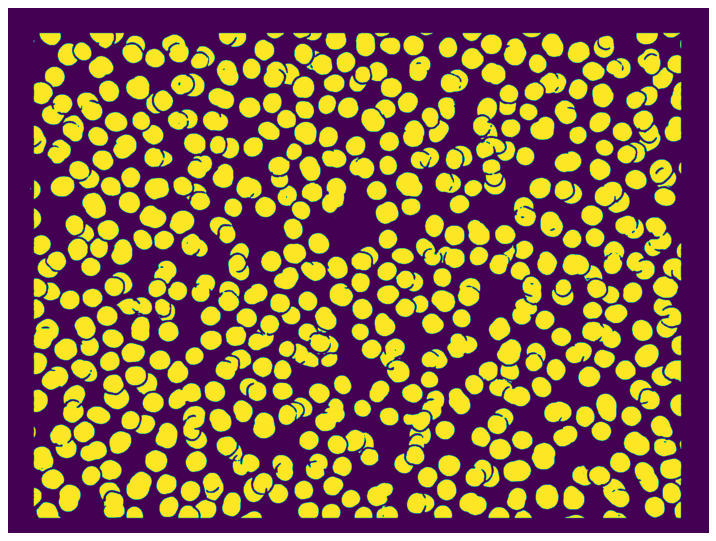

In [221]:
diff = mask - edge_mask



diff = data.scaleBetween(((diff > 127.5) * 1), 0, 255).astype(np.uint8)

fig = plt.figure(figsize=(15, 20), dpi=80)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
lines = 2
columns = 1
fig_num = 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.axis("off")
ax.set_title("")
ax.imshow(diff)

cells number is: 481


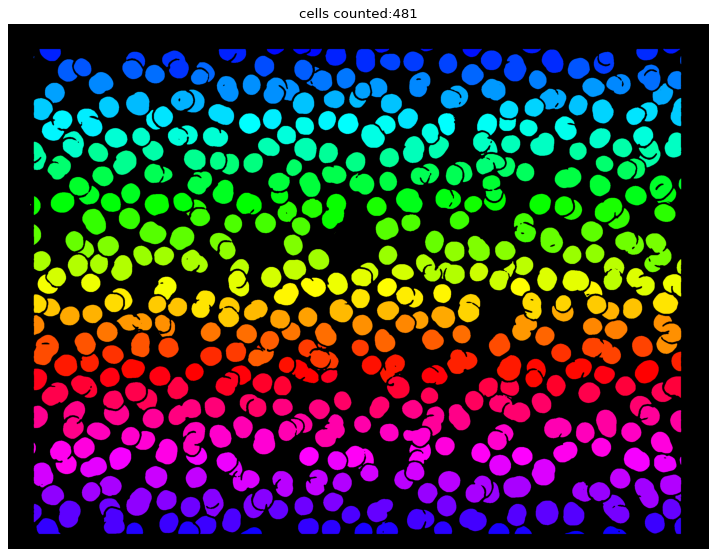

In [225]:
ret, labels = cv2.connectedComponents(diff)

label_hue = np.uint8(179 * labels / np.max(labels))
blank_ch = 255 * np.ones_like(label_hue)
labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
labeled_img[label_hue == 0] = 0


print('cells number is:', ret-1)

fig = plt.figure(figsize=(15, 20), dpi=80)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
lines = 2
columns = 1
fig_num = 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.axis("off")
ax.set_title('cells counted:'+ str(ret-1))
ax.imshow(labeled_img)